In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
# from libs.metrics import aggregators
from libs.metrics import helpers as helpers_metrics
# from libs.visuals import polar_infra
# from libs import latex
from libs.visuals import grid
from libs.visuals import constants as grid_constants

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
APS_OA_DATA_TAR_GZ = '../../../APS/data/final_dataset.tar.gz'
APS_OS_DISCIPLINE_DEMOGRAPHICS = '../../results/interventions/metadata/disciplines_author_demographics.csv'


In [4]:
SUMMARY_PATH = '../../results/interventions/summaries'
VALID_RESPONSES_PATH = '../../results/interventions/valid_responses'
FACTUALITY_PATH = '../../results/interventions/factuality'
PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

In [5]:
vis.sns_reset()
vis.sns_paper_style(font_scale=1.55)

# Plots

In [6]:
BIASED_ATTRIBUTE = 'gender'
PREFIX_BIASED_PROMPT = f'biased_prompt_{BIASED_ATTRIBUTE}'
PREFIX_INRASTRUCTURE = 'infrastructure'

In [18]:
task = constants.EXPERIMENT_TASK_TOPK
task_biased = constants.EXPERIMENT_TASK_BIASED_TOP_K

params = [constants.TASK_TOPK_PARAMS[1]]
params_biased = [c for c in constants.TASK_TOPK_BIASED_PARAMS if BIASED_ATTRIBUTE in c]

# filter out non-biased prompts (top_100)
query = f"grounded == False and task_name == '{task}' and task_param in {params}"
query_biased = f"grounded == False and task_name == '{task_biased}' and task_param in {params_biased}"
intervention_col = 'task_param'

In [19]:
_, df_before_group = helpers_metrics.load_infrastructure_data(query, TABLES_PATH, prefix=PREFIX_INRASTRUCTURE)
_, df_after_group = helpers_metrics.load_infrastructure_data(query_biased, TABLES_PATH, prefix=PREFIX_BIASED_PROMPT)
df_before_group.shape, df_after_group.shape

[2026-01-29 01:42:10] Data successfully saved to ../../results/interventions/tables/biased_prompt_gender_per_attempt.csv
[2026-01-29 01:42:10] Data successfully saved to ../../results/interventions/tables/biased_prompt_gender_per_group.csv


((104, 11), (104, 11))

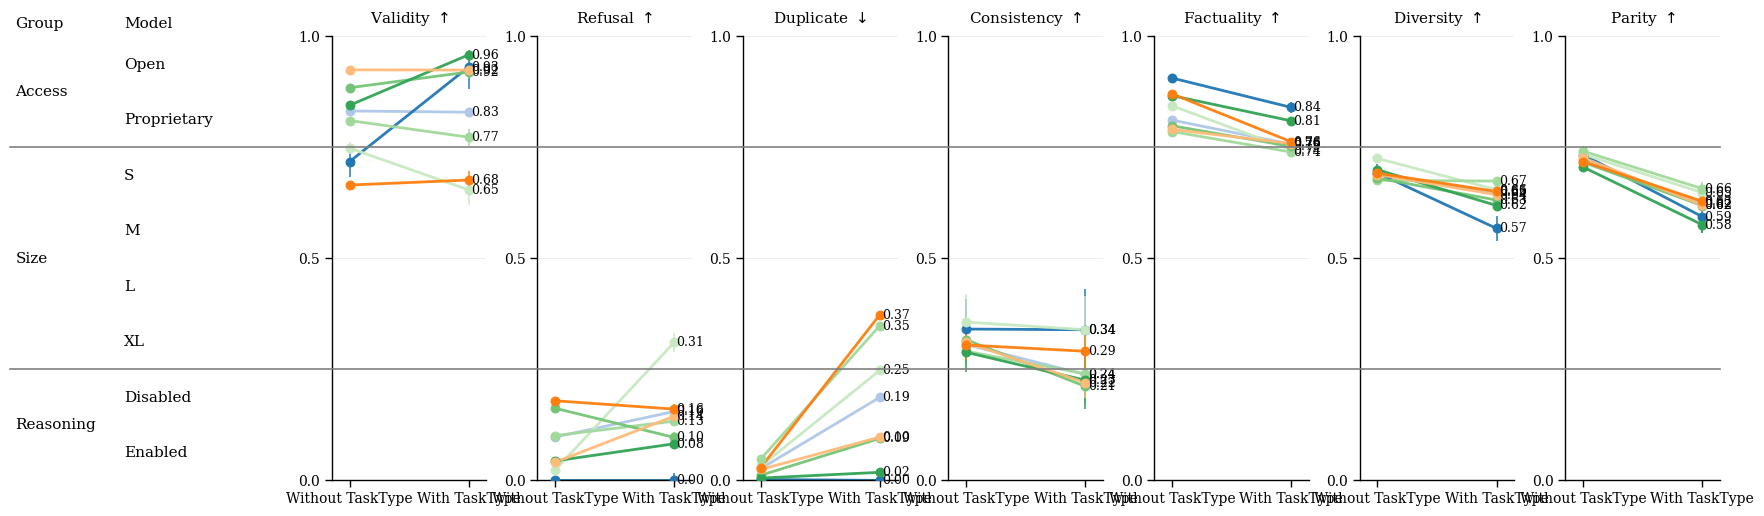

In [21]:

width_ratios = grid.width_ratios_for_split(k_panels=len(grid_constants.PANEL_INFRASTRUCTURE), bars_share=0.8, panel_ratio=1.0)

fig2 = grid.plot_metric_grid_slope2(
    df_before=df_before_group,
    df_after=df_after_group,
    panels=grid_constants.PANEL_INFRASTRUCTURE,
    group_order=grid_constants.GROUPS_ORDER,
    model_order_within_group=grid_constants.MODEL_KIND_ORDER_WITHIN_GROUP,
    group_label_map=grid_constants.GROUP_LABEL_MAP,
    model_label_map=grid_constants.MODEL_KIND_LABEL_MAP,
    group_colors=grid_constants.GROUP_COLORS,
    layout=grid.LayoutSpec(figsize=(18, 6), wspace=0.30),
    style=grid.StyleSpec(),
    ylim=(0, 1),                  # global override for metric axis
    yticks=[0, 0.5, 1.0],
    x_labels=("Without TaskType", "With TaskType"),
    width_ratios=width_ratios,
)
grid.plt.show()
grid.plt.close()

# OLD

In [ ]:
WIDTH = 0.2
FIGSIZE = (10, 2.)
FIGSIZE_TOP = (10, 2.3)
xticklabels_map = {'top_100_bias_gender_equal' : '=', 
                   'top_100_bias_gender_female': 'F', 
                   'top_100_bias_gender_male': 'M', 
                   'top_100_bias_gender_neutral': 'N'}

PLOT_KWARGS = {'figsize':FIGSIZE,  'show_xticks':True, 'xticklabels_map':xticklabels_map, 'width_bar':WIDTH, 'show_xlabel':True, 'xlabel':'bias'}
PLOT_KWARGS_L = {'figsize':FIGSIZE_TOP,  'show_xticks':True, 'xticklabels_map':xticklabels_map, 'width_bar':WIDTH, 'show_legend':True, 'show_xlabel':True, 'xlabel':'bias'}
PLOT_KWARGS_TOP = {'figsize':FIGSIZE, 'show_title':True, 'width_bar':WIDTH, 'show_xticks':True, 
                    'xticklabels_map':xticklabels_map, 'show_xlabel':True, 'xlabel':'bias'}

PREFIX = f'biased_prompt_{BIASED_ATTRIBUTE}'

In [ ]:
for i, metric in enumerate(helpers_metrics.METRICS):
    
    fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=PREFIX)

    per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH).query(query)
    per_attempt = helpers.add_infrastructure_columns(per_attempt)

    per_attempt_biased = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH).query(query_biased)
    per_attempt_biased = helpers.add_infrastructure_columns(per_attempt_biased)

    kwargs = PLOT_KWARGS_TOP if metric in ['validity_pct', 'refusal_pct'] else PLOT_KWARGS_L if metric in ['diversity_gender'] else PLOT_KWARGS
    vis.plot_infrastructural_conditions_comparison_intervention(per_attempt, per_attempt_biased, intervention_col, fn=fn, **kwargs)

